## Implementing Strategy B 

### Differences between Strategy A and Strategy B
"Strategy A" and "Strategy B" have, in common, five scalar parameters required by QLC-2. These are:
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

In Strategy A, four additional parameters are supplied to QLC-2: 
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_{I,corner}$ and $\sigma_{I,middle}$ (water vapor supersaturation above the corner and middle of the crystal)

By contrast, Strategy B's additional parameters are
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

These four parameters are then used to compute the four Strategy A parameters. Specifically, $D_{surf}$ and $\nu_{kin}$ are obtained from the ambient temperature using an Arrhenius formula and the Hertz-Knudsen formula;  $\sigma_{I,corner}$ and $\sigma_{I,middle}$ are obtained from vapor field calculations. The latter are based on the ambient temperature and pressure, the size of the crystal, and far-field vapor parameters $\sigma_{I,far}$ and $x_{far}$. Strategy B is therefore a more integrated and experimentally constrained strategy for parameterizing QLC-2 simulations, but has the drawback that it's harder to isolate specific dependencies (e.g., how the average distance between steps on the surface, $\lambda$ depends on, say $\sigma_{I,corner}$ and $\sigma_{I,middle}$).

### Recap of the equivalent circumference assumption and the circular approximation
Here we recap the results developed in VF_testing2D.ipynb to predict $P_{vap}$ surrounding a square crystal. We first note that the square crystal we are trying to represent has a side length, $L$, and therefore a perimeter ($8L$). We then specify the radius of an "equivalent circular crystal," $L_{equiv}$, such that the circumference of the circular crystal equals the perimeter of the square crystal. This equivalent circle has the property $L < L_{equiv} < L_{corner}$; for example, when $L=50 \ \mu m$, $L_{equiv}=64 \ \mu m$ and $L_{corner}=71 \ \mu m$.

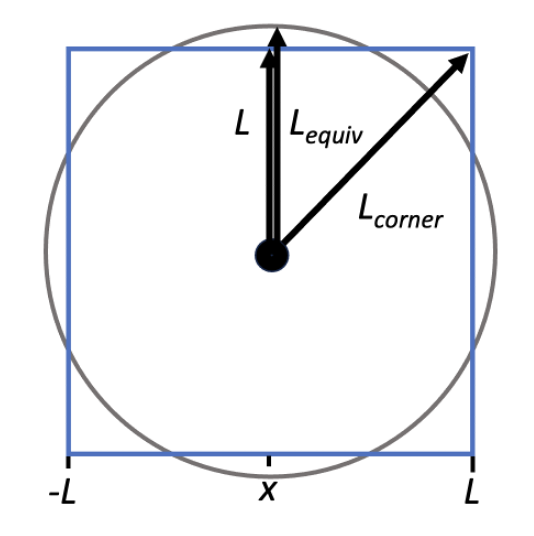

Next, we note that the concentration of vapor around our equivalennt circular crystal has the analytical solution

$$
P_{vap} = P_1 \times (1-{r_0 \over r}) \ \ \ \ (1)
$$

where $P_1$ and $r_0$ depend on $L_{equiv}$, $\sigma_{I,far}$, $x_{far}$, the equilbrium vapor pressure of water at a given temperature, $P_{vap}^{eq}$, and the diffusivity of vapor through air, $D_{vap}$. The latter is computed by

$$
D_{vap} = D_{vap}^o \times { { ({T \over T^o})^m} \over {{P \over P^o}} } \ \ \ \ (2)
$$

(See VF_testing2D.ipynb for details.) Evaluating Eq. 1 at crystal corners leads to

$$
P_{vap}(L) = P_1 \times (1-{r_0 \over L_{corner}}) \ \ \ \ (3)
$$

while evaluation at the middle of facets leads to 

$$
P_{vap}(0) = P_1 \times (1-{r_0 \over L}) \ \ \ \ (4)
$$

A caveat: Eq. 1 assumes that a growing square-shaped crystal influences the overlying vapor field in the same way that a growing circular crystal does. This isn't quite correct: as the numerical solutions in VF_testing2D.ipynb show, for a test case, the equivalent circular approximation produced about double the center reduction obtained by the (more exact) numerical analysis. The reason is, vapor contours close to a square-shaped crystal tend to conform to the flat surfaces of the crystal. That flattening-out reduces differences in vapor concentration between corners and middles of a given side of a square.

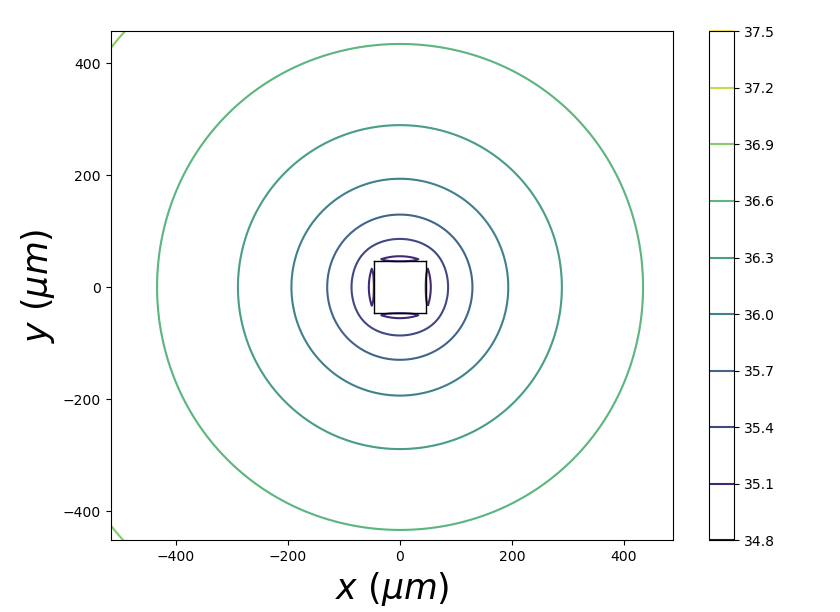

### Iterative solution for determining $g_{ice}$ in Strategy B
For a given set of parameters, Eq. 1 uses an assumed value of the growth rate, $g_{ice}$ to predict a surface vapor concentration profile, $\sigma_I(x)$. The QLC-2 algorithm, meanwhile, takes $\sigma_I(x)$ as input, and produces a value for $g_{ice}$. To obtain a self-consistent growth rate, therefore, requires an iterative approach. Here, we do so in two stages:

1. Use Eq. 1 to map $g_{ice} → \sigma_I(x)$, then use the 0D implementation of QLC-2 to map $\sigma_I(x) → g_{ice}$ (repeat until $g_{ice}$ converged)
1. Use Eq. 1 to map $g_{ice} → \sigma_I(x)$, then use the 1D implementation of QLC-2 to map $\sigma_I(x) → g_{ice}$ (repeat until $g_{ice}$ converged)

The reason for these two stages is that the 0D implementation of QLC-2 does most of the iterative work, and is much faster than the 1D implementation.

### The parabolic approximation for surface vapor concentrations
From the vapor pressures, we can define surface supersaturations relative to the equilibrium vapor pressure, $P_I^*$, according to

$$
\sigma_I(x) = {P_{vap}(x) \over P_I^*}-1 \ \ \ \ (5)
$$

At the middle of the crystal facet, this corresponds to

$$
\sigma_I(0) = {P_{vap}(0) \over P_I^*}-1 \ \ \ \ (6)
$$

while at the corners we have

$$
\sigma_I(L) = {P_{vap}(L) \over P_I^*}-1 \ \ \ \ (7)
$$

It turns out that a parabolic approximation to the vapor supersaturation at the surface of the ice is convenient and sufficiently accurate for our purposes. The curvature of the parabolic will be determined by the "center reduction,"

$$
c_r = 1 - {\sigma_I(0) \over \sigma_I(L)} \ \ \ \ (8)
$$

The parabolic approximation in terms of this curvature is

$$
\sigma_I(x) \approx \sigma_I(L) \times \bigl (c_r ({x \over L})^2 +1 -c_r \bigr )  \ \ \ \ (9)
$$

so that when $x=L$, $\sigma_I(x)=\sigma_I(L)$, and when $x=0$, $\sigma_I(0)$.

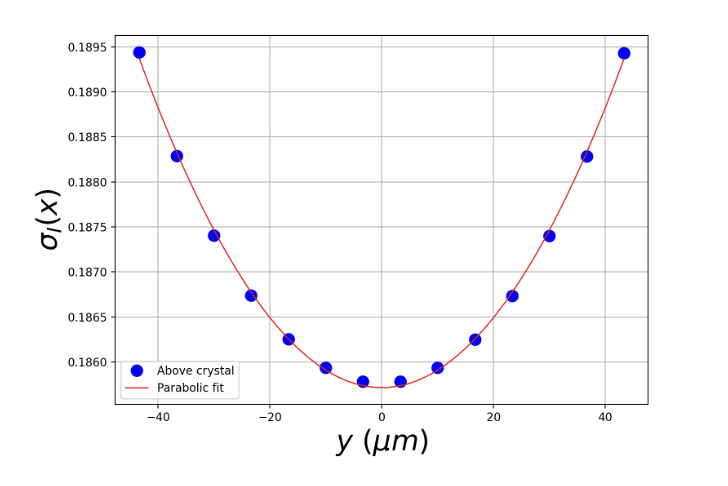

### Implementing Strategy B
The code below implements Strategy B, including the iterative algorithm for $g_{ice}$, for a range of scenarios.

In [21]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload

# QLC-specific code
import QLCstuff as QLC; reload(QLC)
from matplotlib import rcParams

In [22]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### Parameterization
Looks like a good set of base parameters would be: 

    Temperature = AssignQuantity(250,'kelvin')
    Pressure = AssignQuantity(30,'pascal') 
    L = AssignQuantity(30,'micrometer') 
    sigmaI_far_field = 0.25  
    
which gives $\lambda = 1.45$. 

The temperature dependence *is monotonic*:

    If we *raise* the temperature from 250 to 255 K, lambda goes down
    If we *lower* the temperature from 250 to 245 K, lambda goes up

The pressure dependence *is monotonic*:

    If we *raise* the pressure from 30 to 40 pascal, lambda goes down
    If we *lower* the pressure from 30 to 20 pascal, lambda goes up

The size dependence *is monotonic*:

    If we *raise* L from 30 to 40 micrometer, we get lambda goes down
    If we *lower* L from 30 to 20 micrometer, we get lambda goes up

The far-field supersaturation dependence *is monotonic* ...

    If we *raise* sigmaI_far_field from .25 to 0.30, lambda goes down
    If we *lower* sigmaI_far_field from .25 to 0.22, lambda goes up


In [23]:
growing = True
ablating = not growing
exploring_L = True

nmpermonolayer = AssignQuantity(0.5,'nanometer')

if growing:
    Temperature_baseline = AssignQuantity(250,'kelvin')
    Pressure_baseline = AssignQuantity(30,'pascal')
    L_baseline = AssignQuantity(30,'micrometer')
    sigmaI_far_field = AssignQuantity(0.25,'dimensionless')
else:
    Temperature_baseline = AssignQuantity(250,'kelvin')
    Pressure_baseline = AssignQuantity(30,'pascal')
    L_baseline = AssignQuantity(30,'micrometer')
    sigmaI_far_field = AssignQuantity(-0.05,'dimensionless')
    
print(growing)
print(ablating)
print(exploring_L)

True
False
True


In [24]:
parameter_names = ['T', 'P', 'L', 'sigmaI(far)']
result_names = ['c_r(%)', 'D', 'nu_kin', 'g_ice', 'sigmaI_corner','lambda', 'alpha']

In [25]:
# Scenarios
if growing and not exploring_L:

    # Baseline
    parameterlist_mag = [
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on temperature
    [240, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [245, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [255, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [260, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on pressure
    [Temperature_baseline.magnitude, 10, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 15, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 20, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 25, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on far-field supersaturation
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, 0.22],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, 0.23],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, 0.24],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, 0.26],

    # This closes the list 
    ]

elif ablating and not exploring_L:

    # Baseline
    parameterlist_mag = [
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on temperature
    [240, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [245, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [255, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [260, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on pressure
    [Temperature_baseline.magnitude, 10, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 15, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 20, L_baseline.magnitude, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, 25, L_baseline.magnitude, sigmaI_far_field.magnitude],

    # Include these to explore the dependence on far-field supersaturation
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, -0.02],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, -0.03],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, -0.04],

    # This closes the list 
    ]

else: # Exploring L
    
    # Baseline
    parameterlist_mag = [
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, L_baseline.magnitude, sigmaI_far_field.magnitude],

#     # Include these to explore the dependence on crystal size
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 10, sigmaI_far_field.magnitude],
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 20, sigmaI_far_field.magnitude],
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 40, sigmaI_far_field.magnitude],
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 60, sigmaI_far_field.magnitude],
#     [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 80, sigmaI_far_field.magnitude],
    [Temperature_baseline.magnitude, Pressure_baseline.magnitude, 100, sigmaI_far_field.magnitude],

    # This closes the list 
    ]

print(parameterlist_mag)
parameterlist = []
resultslist = []

[[250, 30, 100, 0.25]]


Temperature = 250 kelvin
Pressure = 30 pascal
L = 100 micrometer
sigmaI, far field = 0.25 dimensionless
Dvap = 62773.26202925995 micrometer ** 2 / microsecond
sigma0 = 0.2
P_vap_eq = 80.5128693847561 pascal
P_f = 100.64108673094512 pascal
nu_kin =  105.02534073012481 micrometer / second
nu_kin_mlyperus = 0.21005068146024958 / microsecond
D =  0.00036467519437542267 micrometer ** 2 / microsecond
nx (crystal) = 2001
Spacing of points on the ice surface = 0.09999999999999432 micrometer
L_eff = 127.32395447351627 micrometer
L_middle = 100 micrometer
L_corner = 141.4213562373095 micrometer
g_ice =  2.0 micrometer / second
chi = 1874.9070798983478 dimensionless
growth rates ... 
   from previous vaporfield =  2.0 micrometer / second
   from QLC =  9.864441061011389 micrometer / second
   difference =  -7.864441061011389 micrometer / second
g_ice =  5.9322205305056945 micrometer / second
chi = 632.1097033587595 dimensionless
growth rates ... 
   from previous vaporfield =  5.9322205305056945 

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


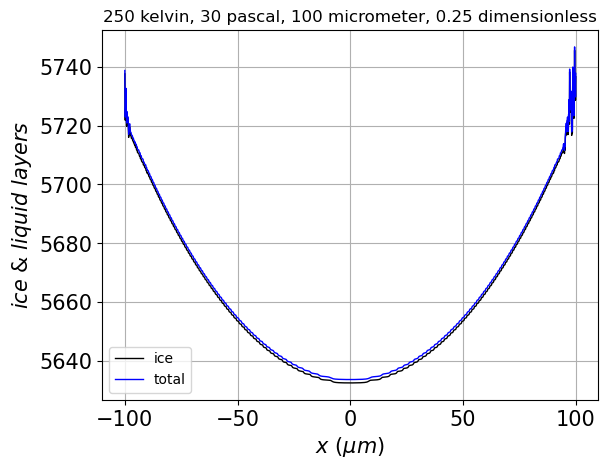

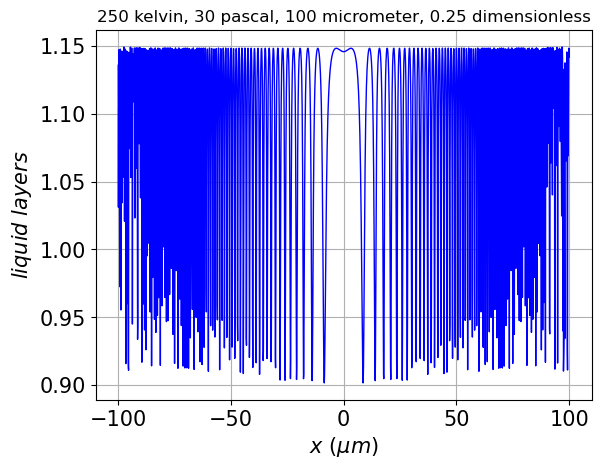

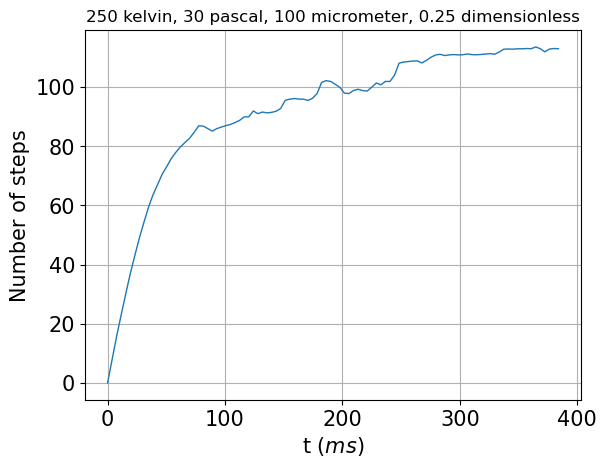

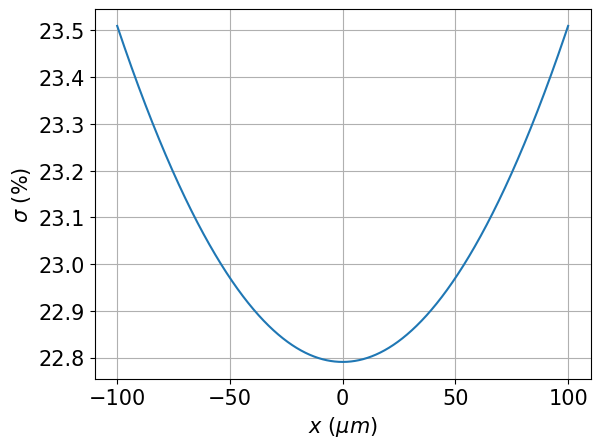

In [26]:
for parameter_magnitudes in parameterlist_mag:

    Temperature = parameter_magnitudes[0]
    Pressure = parameter_magnitudes[1]
    L = parameter_magnitudes[2]
    sigmaI_far_field = parameter_magnitudes[3]

    # Temperature
    Temperature = AssignQuantity(Temperature,'kelvin') 
    print('Temperature =',Temperature)

    # Ambient pressure
    Pressure = AssignQuantity(Pressure,'pascal') 
    print('Pressure =', Pressure)

    # Size of the box
    L = AssignQuantity(L,'micrometer') 
    print('L =', L)

    # The far-field supersaturation
    sigmaI_far_field = AssignQuantity(sigmaI_far_field)
    print('sigmaI, far field =',sigmaI_far_field)

    # The far-field distance
    x_f = AssignQuantity(1000,'micrometer')
    r_f = x_f

    # Diffusion through air
    Dvap = QLC.getDofTP(Temperature,Pressure,AssignQuantity)
    print('Dvap =',Dvap)

    # Difference in equilibrium supersaturation between microsurfaces I and II
    sigma0 = 0.2
    print('sigma0 =',sigma0)

    # Equilibrium vapor stuff
    R = AssignQuantity(8.314,'J/mol/kelvin')
    P3 = AssignQuantity(611,'Pa')
    T3 = AssignQuantity(273,'kelvin')
    Delta_H_sub = AssignQuantity(50,'kJ/mol')
    P_vap_eq = P3*np.exp(-Delta_H_sub/R*(1/Temperature-1/T3))
    print('P_vap_eq =', P_vap_eq)

    # The far-field vapor pressure
    P_f = P_vap_eq * (sigmaI_far_field+1)
    print('P_f =', P_f)

    # Kinetic velocity
    nu_kin = QLC.get_nu_kin(Temperature,AssignQuantity)
    print('nu_kin = ',nu_kin)
    nu_kin_mlyperus = nu_kin/nmpermonolayer
    nu_kin_mlyperus.ito('1/microsecond')
    print('nu_kin_mlyperus =', nu_kin_mlyperus)

    # Surface diffusion coefficient
    D = QLC.get_D_of_T(Temperature,AssignQuantity)
    print('D = ',D)

    # Properties of the QLL
    Nbar = 1.0
    Nstar = .9/(2*np.pi)

    # The equilibration time
    tau_eq = AssignQuantity(1,'microsecond')

    # Number of points on the ice surface
    Lx_reference = AssignQuantity(75,'micrometer')
    nx_crystal = int(1501*L/Lx_reference)
    print('nx (crystal) =', nx_crystal)
    x_QLC = np.linspace(-L,L,nx_crystal)
    deltax = x_QLC[1]-x_QLC[0]
    print('Spacing of points on the ice surface =', deltax)
    Doverdeltax2 = D/deltax**2

    # Calculating the radius of the equivalent circle (the notation L_equiv is used in the documentation cell above)
    perimeter_of_crystal = 8*L
    L_equiv = L_eff = perimeter_of_crystal/(2*np.pi)
    print('L_eff =',L_eff)
    L_middle = L
    print('L_middle =',L_middle)
    L_corner = L*2**.5
    print('L_corner =',L_corner)
    
    # Now the 0d self-consistency loop
    rho_ice = AssignQuantity(0.9,'g/cm^3')
    Mvap = AssignQuantity(18,'g/mol')
    g_ice = AssignQuantity(2,'micrometer/second')
    g_ice_QLC = g_ice
    Ntot_init_0D = 0
    NQLL_init_0D = QLC.getNQLL(Ntot_init_0D,Nstar,Nbar)

    # Time steps
    ntimes = 200
    tlast = AssignQuantity(1000,'microsecond')
    tkeep_0Darr = np.linspace(0,tlast.magnitude,ntimes)
    tkeep_0Darr = AssignQuantity(tkeep_0Darr,'microsecond')
    
    # Looping over 0-D dynamics to get g_ice right
    for i in range(6):

        # Use our analytical vaporfield result to predict the vapor at the middle and corner of the crystal
        g_ice = (g_ice+g_ice_QLC)/2
        print('g_ice = ',g_ice)
        g_vap = rho_ice*g_ice*R*Temperature/Mvap; #print(gprime)
        g_vap.ito('pascal * micrometer / second'); #print(gprime)
        gprime = g_vap # Renaming this because it's called gprime in the code below
        chi = Dvap*P_f*r_f/(gprime*L_eff**2); chi.ito('dimensionless'); print('chi =', chi)
        r_0 = r_f/(1+chi); # print('r0 =', r_0)
        P1 = P_f/(1-r_0/r_f)
        P_vap_corner = P1*(1-r_0/L_corner)
        
        # Let the supersaturation at the crystal corner represent the 0-D crystal
        sigmaI_corner = P_vap_corner/P_vap_eq - 1

        # Solve the 0d QLC trajectory with the revised sigmaI
        Ntotkeep_0D, NQLLkeep_0D = QLC.run_f0d(\
                NQLL_init_0D, Ntot_init_0D, tkeep_0Darr,\
                Nbar, Nstar, sigma0, nu_kin_mlyperus, tau_eq, sigmaI_corner)
        Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

        # Report
        g_ice_QLC = QLC.report_0d_growth_results(\
                    tkeep_0Darr,NQLLkeep_0D,Ntotkeep_0D,Nicekeep_0D,Nbar,Nstar,nmpermonolayer,graphics=False)
        print('growth rates ... ')
        print('   from previous vaporfield = ',g_ice)
        print('   from QLC = ',g_ice_QLC)
        print('   difference = ',g_ice-g_ice_QLC)

    print('Done with the 0d self-consistency loop')
    
    # Now the 1D self-consistency

    # Estimating/deciding on how long to make the integration
    print('Estimating times for the trajectory run')
    L_reference = AssignQuantity(1,'millimeter')
    time_reference = AssignQuantity(1,'millisecond')
    tlast_estimated = (L*L_reference/D*time_reference)**.5*1.1
    tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
    tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)
    tlast = tlast_msec.to('microsecond')
    if growing:
        tlast /= 1.5
    else:
        tlast *= 1.5

    # Number of time steps to report back
    ntimes = 100
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

    # Reporting flag
    verbose = 1

    for i in range(6):

        # Use our analytical result to predict the vapor at the surface of the crystal
        g_ice = (g_ice+g_ice_QLC)/2
        print('g_ice = ',g_ice)
        g_vap = rho_ice*g_ice*R*Temperature/Mvap; #print(gprime)
        g_vap.ito('pascal * micrometer / second'); #print(gprime)
        gprime = g_vap # Renaming this because it's called gprime in the code below
        chi = Dvap*P_f*r_f/(gprime*L_eff**2); chi.ito('dimensionless'); print('chi =', chi)
        r_0 = r_f/(1+chi); # print('r0 =', r_0)
        P1 = P_f/(1-r_0/r_f)
        
        # Find the supersaturation across the crystal
        P_vap_middle = P1*(1-r_0/L_middle)
        P_vap_corner = P1*(1-r_0/L_corner)
        sigmaI_corner = P_vap_corner/P_vap_eq - 1
        sigmaI_middle = P_vap_middle/P_vap_eq - 1
        c_r = 1-sigmaI_middle/sigmaI_corner
        c_r_percent = c_r*100
        print('c_r(%) =', c_r_percent)
        sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)

        # Solve the 1-D problem
        Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                        NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                        Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                        AssignQuantity,\
                        verbose=0, odemethod='LSODA')
        Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

        # Report
        g_ice_QLC = QLC.report_1d_growth_results(\
            x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
            graphics=False)
        print('growth rates ... ')
        print('   from previous vaporfield = ',g_ice)
        print('   from QLC = ',g_ice_QLC)
        print('   c_r(%) =', c_r_percent)
        
    # Reporting (should fix this with title_params = "{:.0f}".format(this_time.magnitude))
    title_params = str(Temperature)+', '+str(Pressure)+', '+str(L)+', '+str(sigmaI_far_field)
    g_ice_QLC = QLC.report_1d_growth_results(\
            x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
            title_params=title_params)
    
    plt.figure()
    plt.plot(x_QLC,sigmaI_QLC*100)
    plt.grid(True)
    plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    
    print('final g_ice_QLC =',g_ice_QLC)

    alpha = g_ice_QLC/(sigmaI_far_field*nu_kin)
    print('alpha far-field (%) =',alpha*100)
    alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
    print('alpha surface (%) =',alpha*100)

    lastfraction = 0.3
    itimes_almost_end = int(ntimes*(1-lastfraction))
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps_ss = np.mean(f[itimes_almost_end:-1])
    print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
    lambda_average = L/nsteps_ss
    print('estimated lambda =', lambda_average)

    results = [c_r_percent, D, nu_kin, g_ice_QLC, sigmaI_corner, lambda_average, alpha]
    resultslist.append(results)
    parameters = [Temperature,Pressure,L,sigmaI_far_field]
    parameterlist.append(parameters)
    print('Done with scenario ', len(resultslist))
    print('--------------------')

### Reporting

### Graphing results as a function of parameters

In [27]:
# Reminder of the parameters and results
print(parameter_names)
print(result_names)

['T', 'P', 'L', 'sigmaI(far)']
['c_r(%)', 'D', 'nu_kin', 'g_ice', 'sigmaI_corner', 'lambda', 'alpha']


In [28]:
# Repackaging the parameters
T_list = np.empty(0)
P_list = np.empty(0)
L_list = np.empty(0)
sigmaI_far_field_list = np.empty(0)
for this_parameterset in parameterlist:
    T_list = np.append(T_list,this_parameterset[0])
    P_list = np.append(P_list,this_parameterset[1])
    L_list = np.append(L_list,this_parameterset[2])
    sigmaI_far_field_list = np.append(sigmaI_far_field_list,this_parameterset[3])
print('parameters:\n')
print(T_list)
print(P_list)
print(L_list)
print(sigmaI_far_field_list)

# Repackaging the results
c_r_percent_list = np.empty(0)
D_list = np.empty(0)
nu_kin_list = np.empty(0)
g_ice_list = np.empty(0)
sigmaI_corner_list = np.empty(0)
lambda_average_list = np.empty(0)
alpha_list = np.empty(0)

for this_resultset in resultslist:
    c_r_percent_list = np.append(c_r_percent_list,this_resultset[0])
    D_list = np.append(D_list,this_resultset[1])
    nu_kin_list = np.append(nu_kin_list,this_resultset[2])
    g_ice_list = np.append(g_ice_list,this_resultset[3])
    sigmaI_corner_list = np.append(sigmaI_corner_list,this_resultset[4])
    lambda_average_list = np.append(lambda_average_list,this_resultset[5])
    alpha_list = np.append(alpha_list,this_resultset[6])

c_r_list = c_r_percent_list/100    
print()
print('results:\n')
print('c_r(%) =', c_r_percent_list,'\n')
print('D =', D_list,'\n')
print('nu_kin =', nu_kin_list,'\n')
print('g_ice =', g_ice_list,'\n')
print('sigmaI_corner =', sigmaI_corner_list,'\n')
print('lambda =', lambda_average_list,'\n')
print('alpha =', alpha_list,'\n')

z_list = (D_list/c_r_list/nu_kin_list)**.5
z_list.ito('micrometer^.5')
print('z =',z_list)

parameters:

[250.0] kelvin
[30.0] pascal
[100.0] micrometer
[0.25] dimensionless

results:

c_r(%) = [3.058283631973302] dimensionless 

D = [0.00036467519437542267] micrometer ** 2 / microsecond 

nu_kin = [105.02534073012481] micrometer / second 

g_ice = [7.346022852124687] micrometer / second 

sigmaI_corner = [0.2350967769113328] dimensionless 

lambda = [0.8949142559376395] micrometer 

alpha = [0.29751680442154604] dimensionless 

z = [10.655336802030638] micrometer ** 0.5


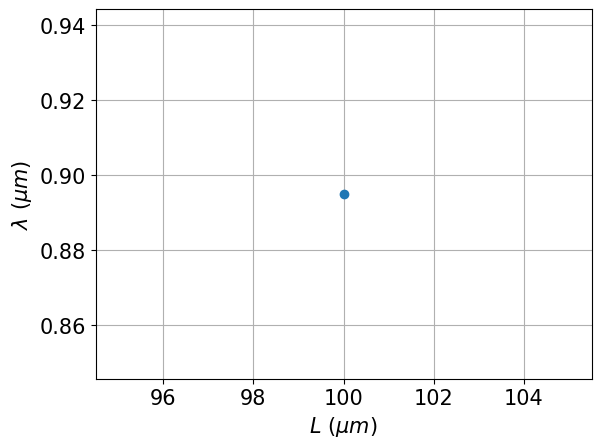

In [29]:
# This does some plotting as a function of L
if exploring_L:
    plt.figure()
    xp = L_list
    yp = lambda_average_list
    ixsort = np.argsort(xp)
    x = xp[ixsort]
    y = yp[ixsort]
    plt.plot(x,y,'o')
    plt.xlabel('$L \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    if len(x) > 2: # Need to change this to exponential fit
        p = np.polyfit(x.magnitude,y.magnitude,2)
        plt.plot(x.magnitude,np.polyval(p,x.magnitude))
        print(np.flip(p))
    plt.grid(True)

In [30]:
# This does some plotting as a function of z
if not exploring_L:
    plt.figure()
    zp = (D_list/c_r_list/nu_kin_list)**.5
    zp.ito('micrometer^.5')
    izsort = np.argsort(zp)
    x = zp[izsort]
    y = lambda_average_list[izsort]
    plt.plot(x,y,'o')
    plt.xlabel('$z \ (\mu m^{1/2}$)',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    if len(x)>2:
        p = plt.polyfit(x.magnitude,y.magnitude,1)
        plt.plot(x,plt.polyval(p,x.magnitude))
        print(np.flip(p))
    plt.grid(True)